In [104]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict
import plotly.express as px
import matplotlib.pyplot as plt

In [67]:
def compute_similarities_based_on_features(features_df, year_col, month_col, day_col):

    # Add week number to features_df
    features_df["date"] = pd.to_datetime(
        features_df[year_col].astype(int).astype(str)
        + "-"
        + features_df[month_col].astype(int).astype(str)
        + "-"
        + features_df[day_col].astype(int).astype(str)
    )
    features_df["week"] = features_df["date"].dt.isocalendar().week

    grouped = features_df.groupby([year_col, "week"])
    features_columns = [
        col
        for col in features_df.columns
        if (col.startswith("voc_") or col.startswith("lex_") or col.startswith("liwc_"))
    ]

    weeks = []
    years = []
    variances = defaultdict(list)
    means = defaultdict(list)

    for name, group in grouped:
        year, week = name
        for col in features_columns:
            try:
                variances[col].append(group[col].var())
                means[col].append(group[col].mean())
            except:
                variances[col].append(np.nan)
                means[col].append(np.nan)
        weeks.append(week)
        years.append(year)

    variances_df = pd.DataFrame({"year": years, "week": weeks})
    for col in features_columns:
        variances_df[f"similarity_{col}"] = variances[col]
        variances_df[f"mean_{col}"] = means[col]

    return variances_df

In [68]:
def clean_similarities(data):
    data["year"] = data["year"].astype(float).astype(int)
    data["week"] = data["week"].astype(float).astype(int)

    # only keep the rows with year >= 2018
    data = data[data["year"] >= 2018]

    # sort the data by year and month
    # Fill NaN values with mean of each column
    data = data.fillna(data.mean())
    data = data.set_index(["year", "week"]).sort_index().reset_index()

    return data

In [69]:
papers_features = pd.read_csv("papers/cl_cv_papers_features.csv")
news_features = pd.read_csv("news/news_features.csv")
reddit_features = pd.read_csv("reddit/reddit_features.csv")

/tmp/ipykernel_526957/59441959.py:1: DtypeWarning: Columns (249,256) have mixed types. Specify dtype option on import or set low_memory=False.
  papers_features = pd.read_csv("papers/cl_cv_papers_features.csv")
/tmp/ipykernel_526957/59441959.py:2: DtypeWarning: Columns (0,249) have mixed types. Specify dtype option on import or set low_memory=False.
  news_features = pd.read_csv("news/news_features.csv")


In [70]:
papers_features["final_date"] = pd.to_datetime(papers_features["final_date"])
papers_features["day"] = papers_features["final_date"].dt.day

In [71]:
reddit_features["created_utc"] = pd.to_datetime(reddit_features["created_utc"])
reddit_features["day"] = reddit_features["created_utc"].dt.day

In [72]:
papers_features = papers_features.dropna(subset=["year", "month", "day"])
news_features = news_features.dropna(subset=["year", "month", "day"])
reddit_features = reddit_features.dropna(subset=["year", "month", "day"])

In [ ]:
papers_similarities = compute_similarities_based_on_features(
    papers_features, "year", "month", "day"
)
news_similarities = compute_similarities_based_on_features(
    news_features, "year", "month", "day"
)
reddit_similarities = compute_similarities_based_on_features(
    reddit_features, "year", "month", "day"
)

In [74]:
papers_clean_similarities = clean_similarities(papers_similarities)
news_clean_similarities = clean_similarities(news_similarities)
reddit_clean_similarities = clean_similarities(reddit_similarities)

In [93]:
papers_threshold = 0.82
papers_ai_detection_df = pd.read_csv("papers/cl_cv_papers_ai_written.csv")
papers_ai_detection_df["final_date"] = pd.to_datetime(
    papers_ai_detection_df["final_date"]
)
papers_ai_detection_df["week"] = (
    papers_ai_detection_df["final_date"].dt.isocalendar().week
)

papers_ai_detection_df["ai_written"] = (
    papers_ai_detection_df["ai_written"] < papers_threshold
)

papers_ai_detection_df = papers_ai_detection_df[papers_ai_detection_df["year"] >= 2018]
papers_ai_detection_df = (
    papers_ai_detection_df.groupby(["year", "week"])["ai_written"].mean().reset_index()
)

/tmp/ipykernel_526957/944230634.py:10: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



In [94]:
news_threshold = 0.83
news_ai_detection_df = pd.read_csv("news/news_ai_written.csv")
news_ai_detection_df["date"] = pd.to_datetime(
    news_ai_detection_df["year"].astype(int).astype(str)
    + "-"
    + news_ai_detection_df["month"].astype(int).astype(str)
    + "-"
    + news_ai_detection_df["day"].astype(int).astype(str)
)
news_ai_detection_df["week"] = news_ai_detection_df["date"].dt.isocalendar().week


news_ai_detection_df["ai_written"] = news_ai_detection_df["ai_written"] < news_threshold

news_ai_detection_df = news_ai_detection_df[news_ai_detection_df["year"] >= 2018]
news_ai_detection_df = (
    news_ai_detection_df.groupby(["year", "week"])["ai_written"].mean().reset_index()
)

In [95]:
reddit_threshold = 0.87
reddit_ai_detection_df = pd.read_csv("reddit/reddit_ai_written.csv")
reddit_ai_detection_df["created_utc"] = pd.to_datetime(
    reddit_ai_detection_df["created_utc"]
)
reddit_ai_detection_df["week"] = (
    reddit_ai_detection_df["created_utc"].dt.isocalendar().week
)

reddit_ai_detection_df["ai_written"] = (
    reddit_ai_detection_df["ai_written"] < reddit_threshold
)

reddit_ai_detection_df = reddit_ai_detection_df[reddit_ai_detection_df["year"] >= 2018]
reddit_ai_detection_df = (
    reddit_ai_detection_df.groupby(["year", "week"])["ai_written"].mean().reset_index()
)

In [96]:
papers_clean_similarities = papers_clean_similarities.drop(
    [col for col in papers_clean_similarities.columns if col.startswith("mean_")],
    axis=1,
)

papers_merged_df = pd.merge(
    papers_clean_similarities,
    papers_ai_detection_df,
    on=["year", "week"],
    how="left",
    suffixes=("", "_ai"),
)


news_clean_similarities = news_clean_similarities.drop(
    [col for col in news_clean_similarities.columns if col.startswith("mean_")], axis=1
)

news_merged_df = pd.merge(
    news_clean_similarities,
    news_ai_detection_df,
    on=["year", "week"],
    how="left",
    suffixes=("", "_ai"),
)

reddit_clean_similarities = reddit_clean_similarities.drop(
    [col for col in reddit_clean_similarities.columns if col.startswith("mean_")],
    axis=1,
)

reddit_merged_df = pd.merge(
    reddit_clean_similarities,
    reddit_ai_detection_df,
    on=["year", "week"],
    how="left",
    suffixes=("", "_ai"),
)

In [98]:
columns_about_complexity = [
    "voc_simpson_index",
    "voc_shannon_entropy",
    "lex_avg_dependency_link_length",
    "voc_type_token_ratio",
    "voc_hapax_legomena",
]

In [101]:
def get_top_correlated_features_wrt_ai_detection(merged_df):
    # compute the correlation between each feature and the ai_written + num_errors
    merged_correlation_df = merged_df.set_index(["year", "week"]).corr()
    merged_correlation_df = merged_correlation_df.loc[["ai_written"]]

    ai_top_correlated_features = (
        merged_correlation_df.loc["ai_written"].abs().nlargest(10)
    )
    ai_top_correlated_features = list(
        set(
            [
                *ai_top_correlated_features.index.tolist(),
                *[f"similarity_{col}" for col in columns_about_complexity],
            ]
        )
    )
    ai_top_correlated_df = merged_correlation_df.loc["ai_written"].loc[
        ai_top_correlated_features
    ]
    return ai_top_correlated_df

In [102]:
papers_ai_top_correlated_df = get_top_correlated_features_wrt_ai_detection(
    papers_merged_df
)
news_ai_top_correlated_df = get_top_correlated_features_wrt_ai_detection(news_merged_df)
reddit_ai_top_correlated_df = get_top_correlated_features_wrt_ai_detection(
    reddit_merged_df
)

In [103]:
len(papers_ai_top_correlated_df), len(news_ai_top_correlated_df), len(
    reddit_ai_top_correlated_df
)

(15, 14, 13)

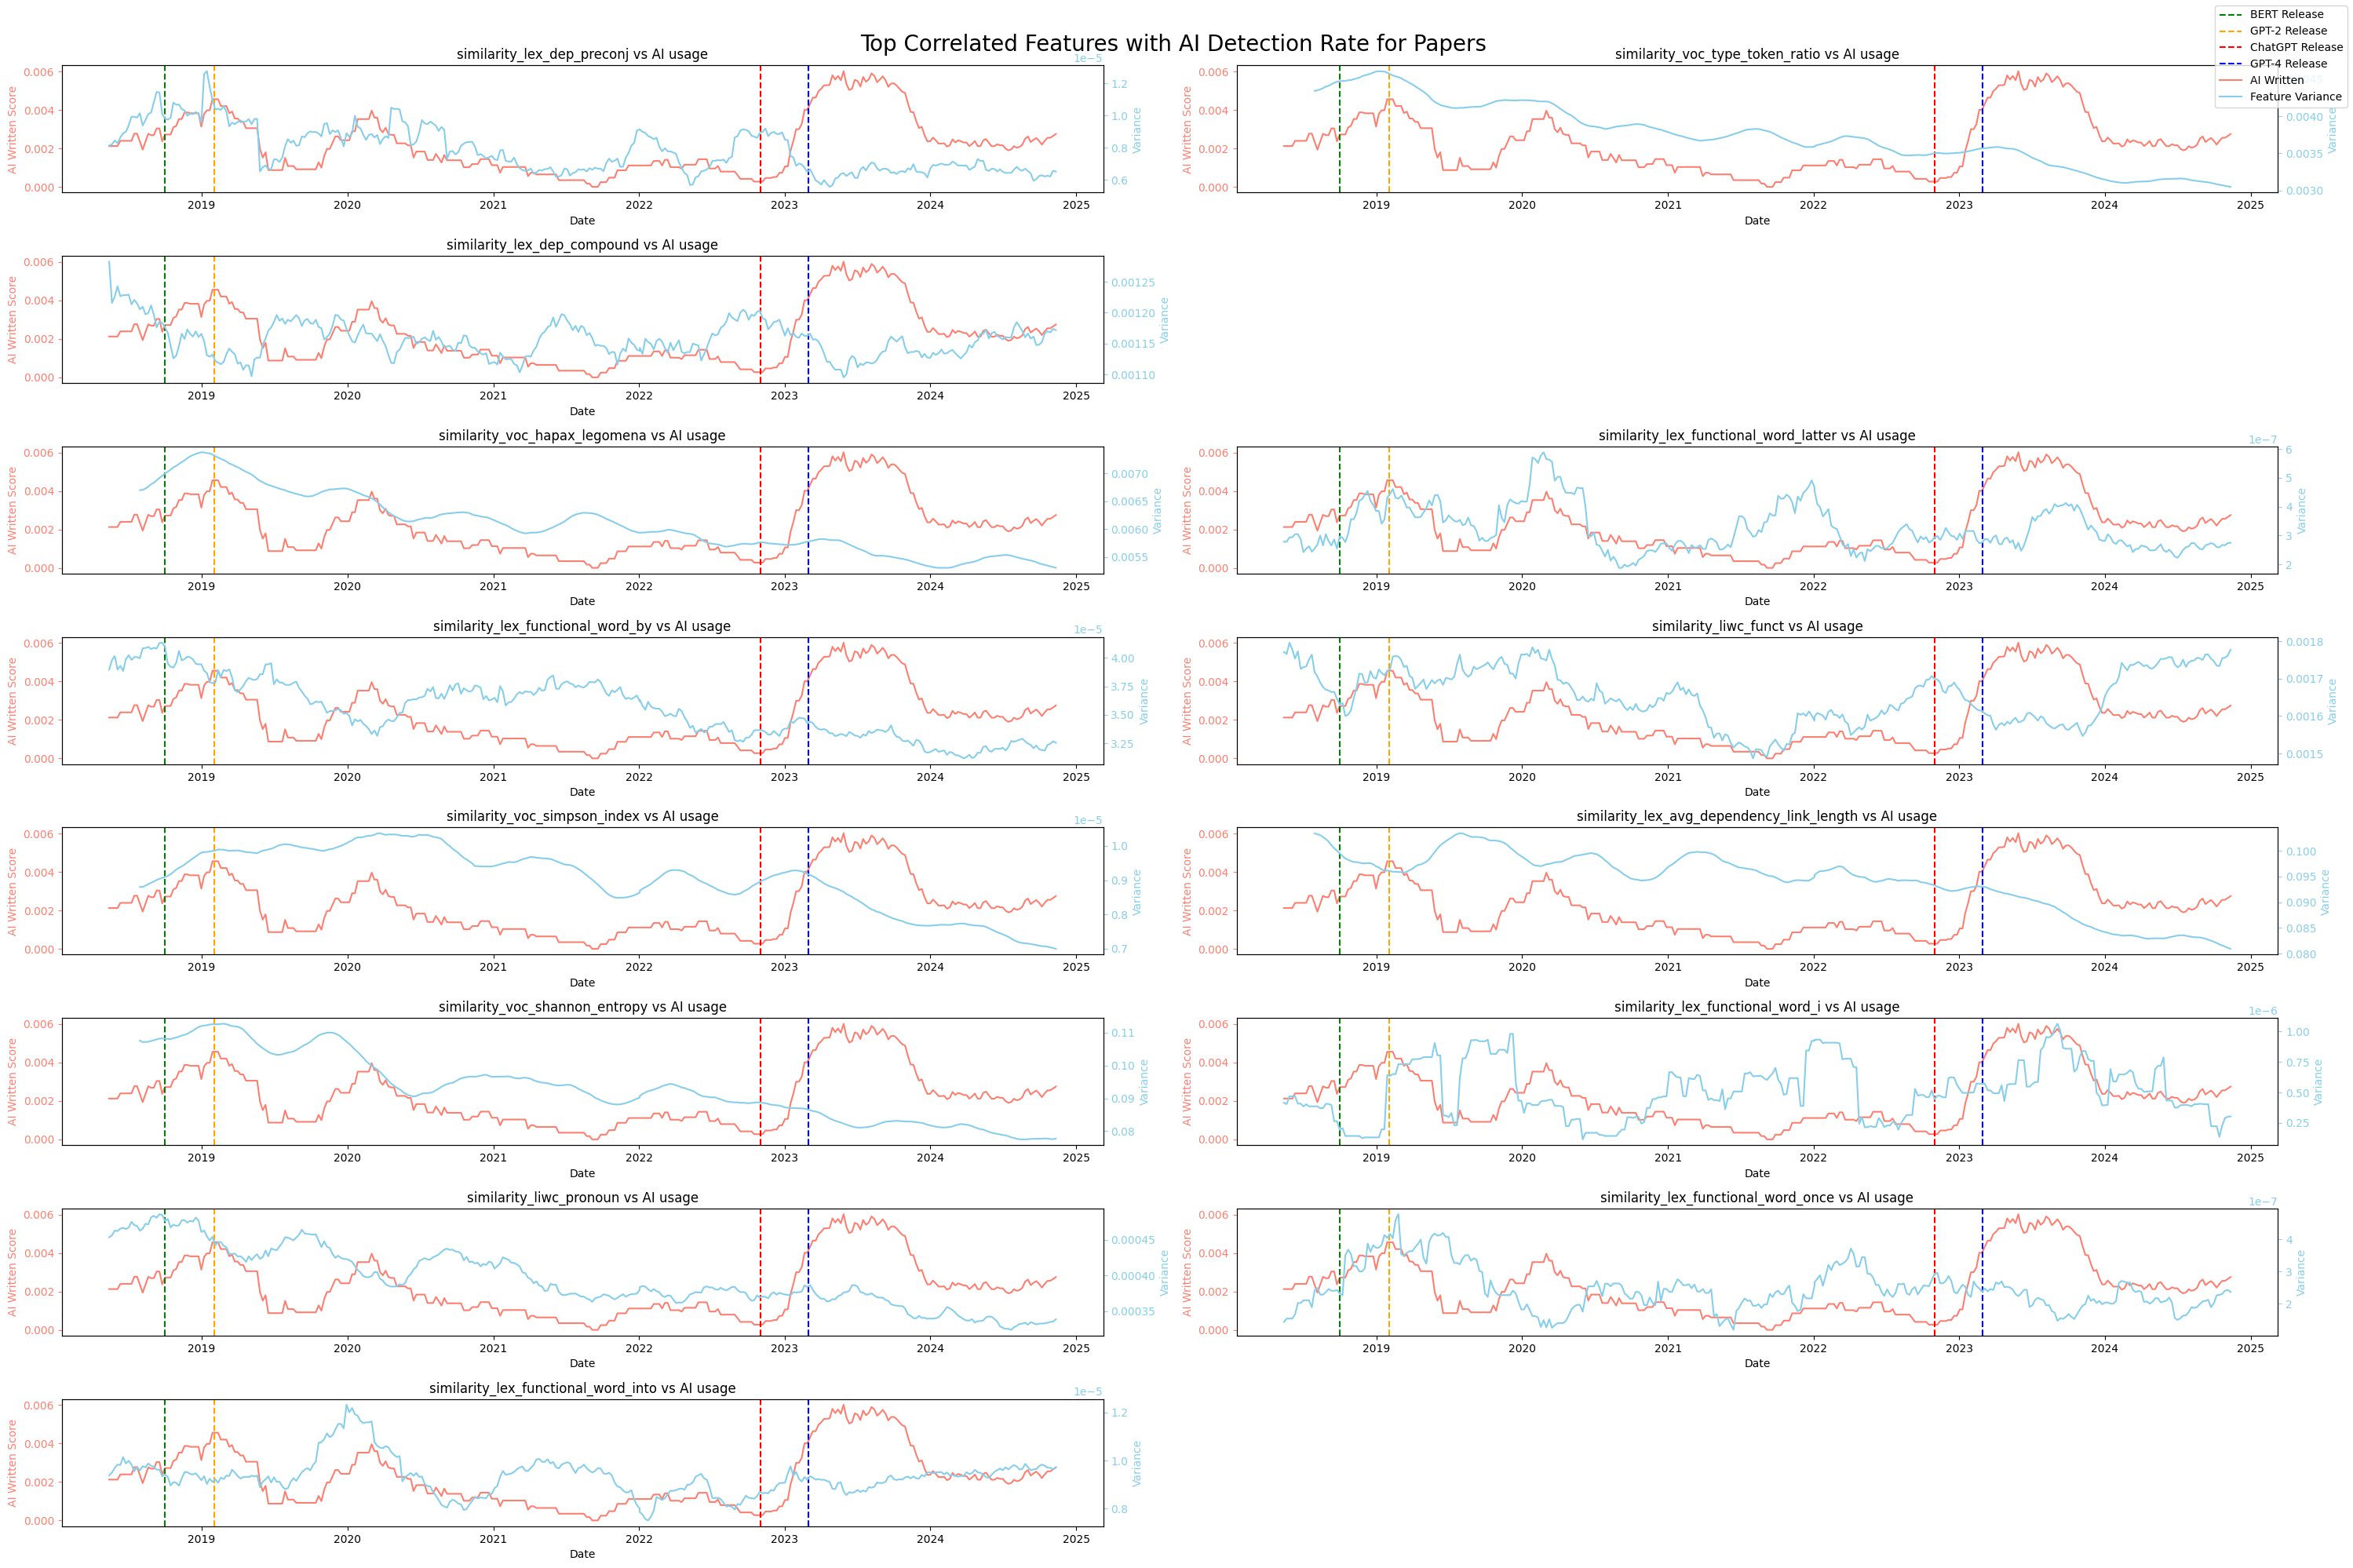

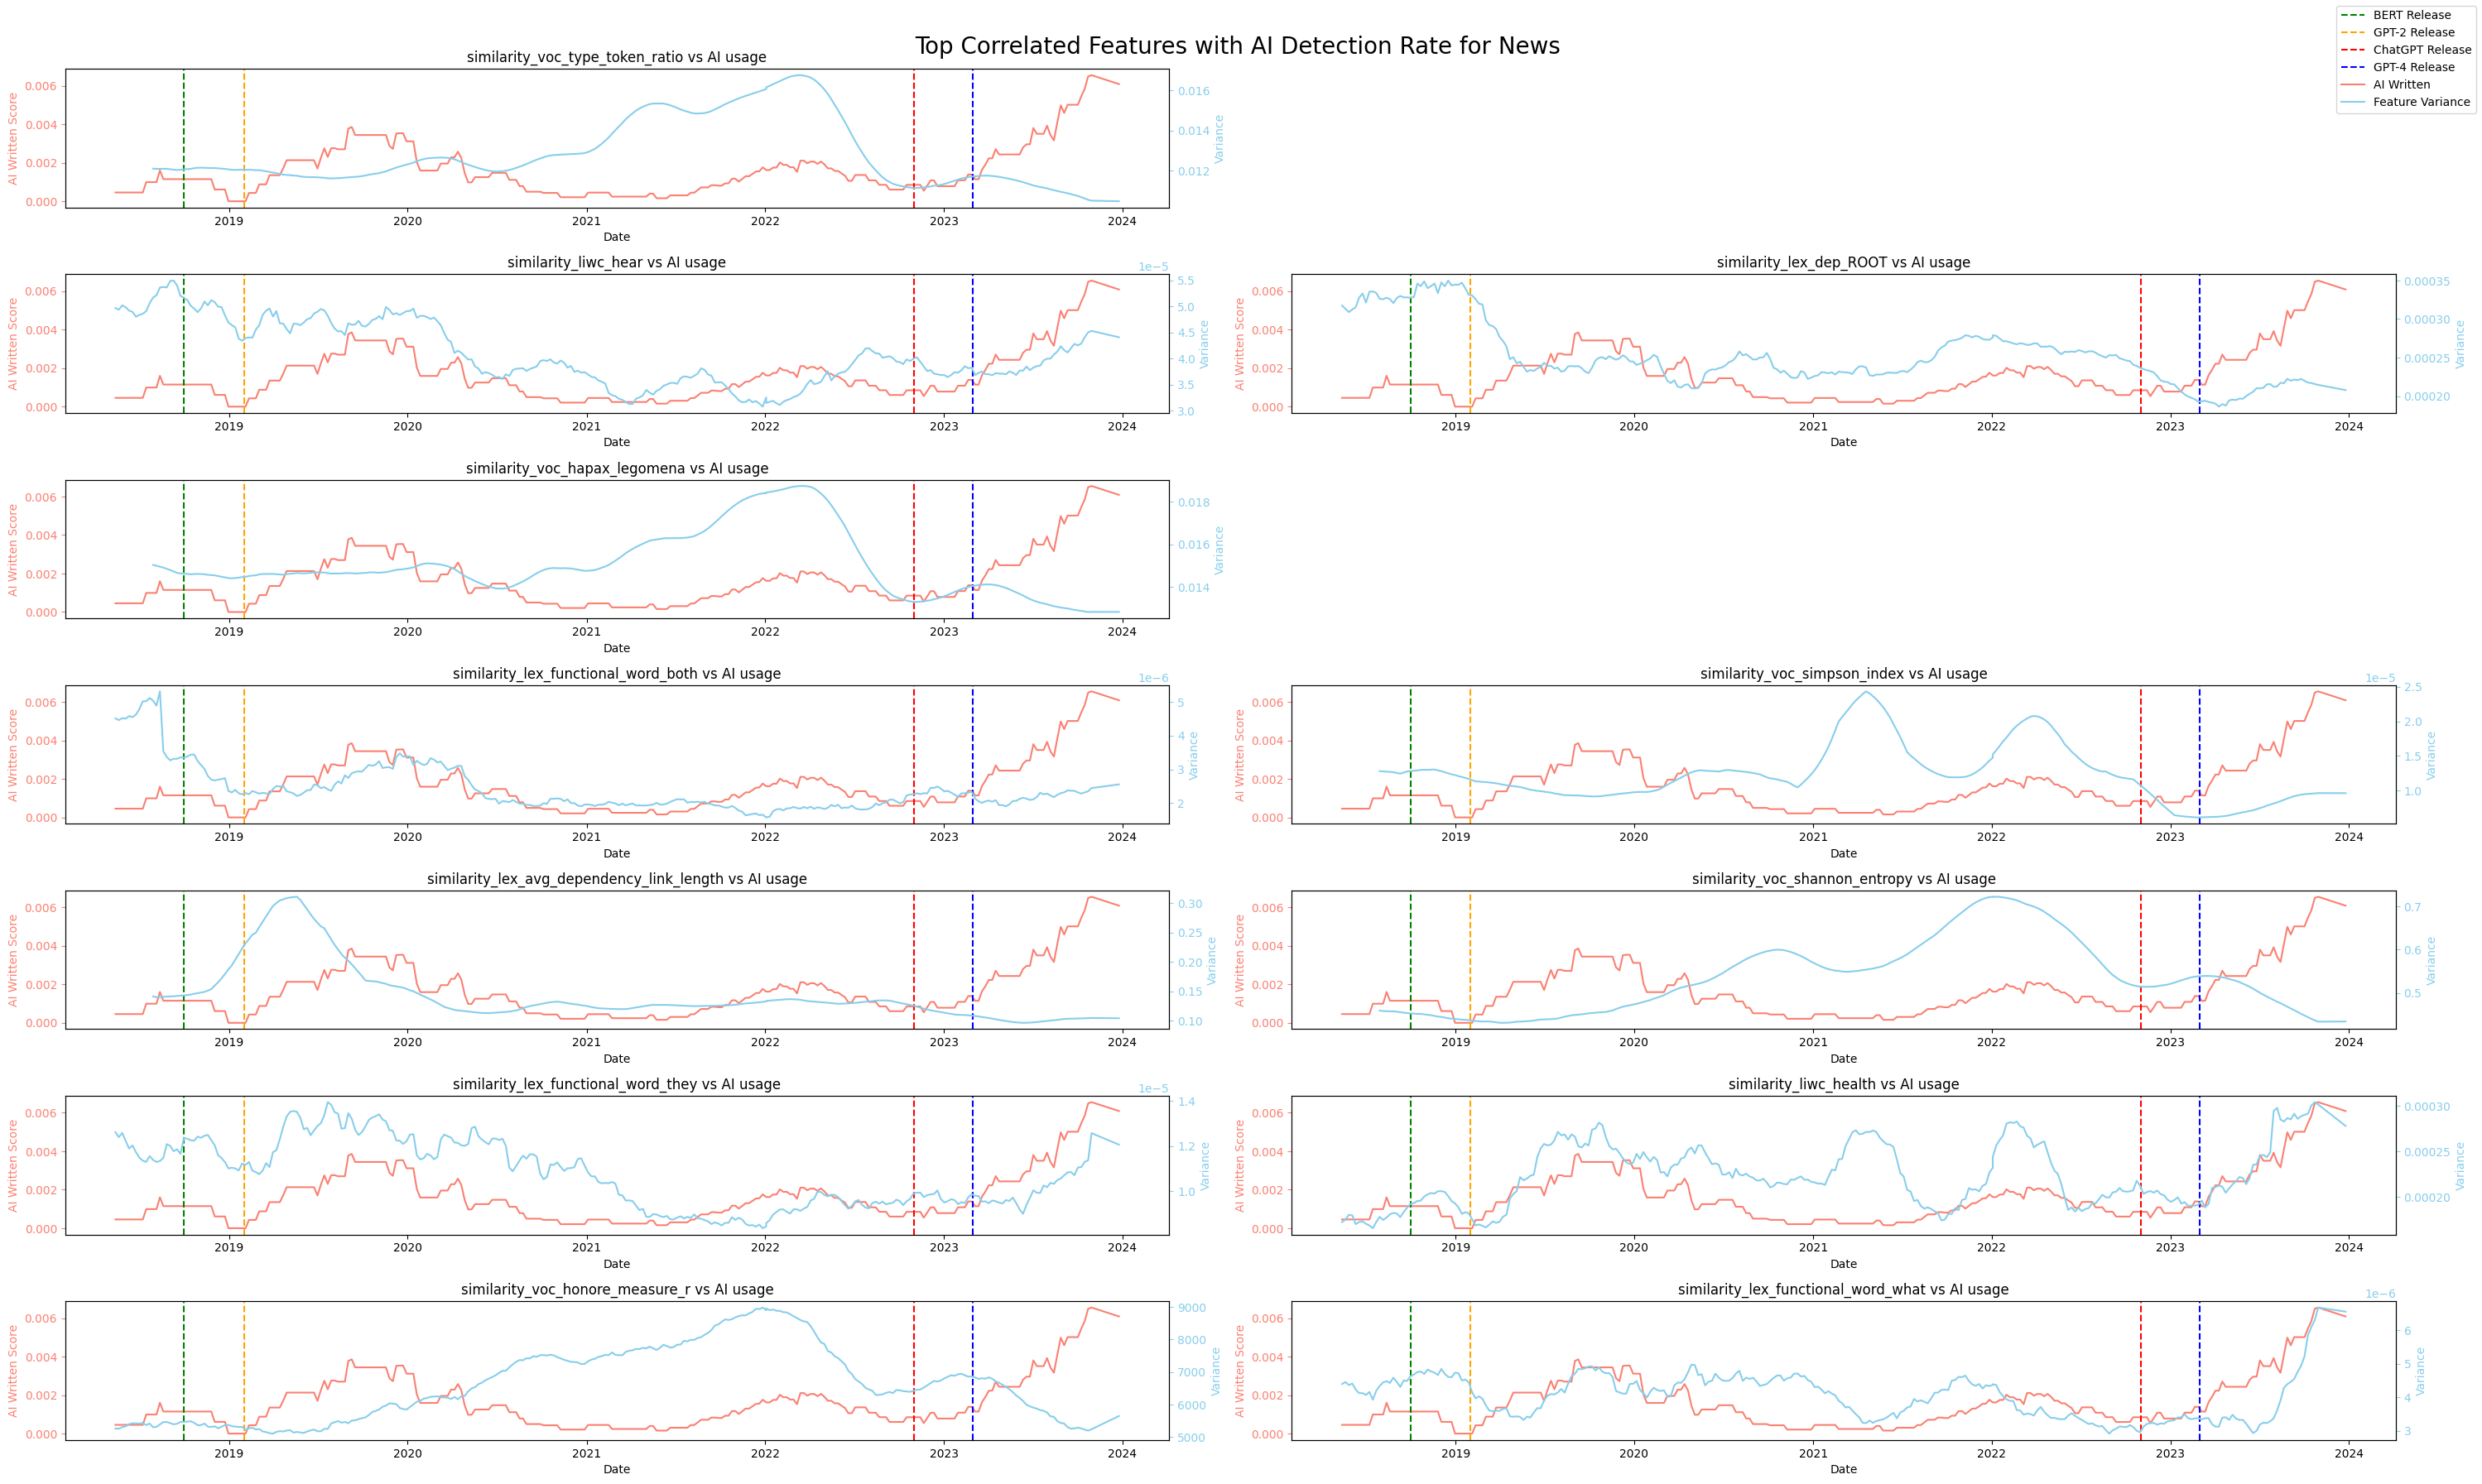

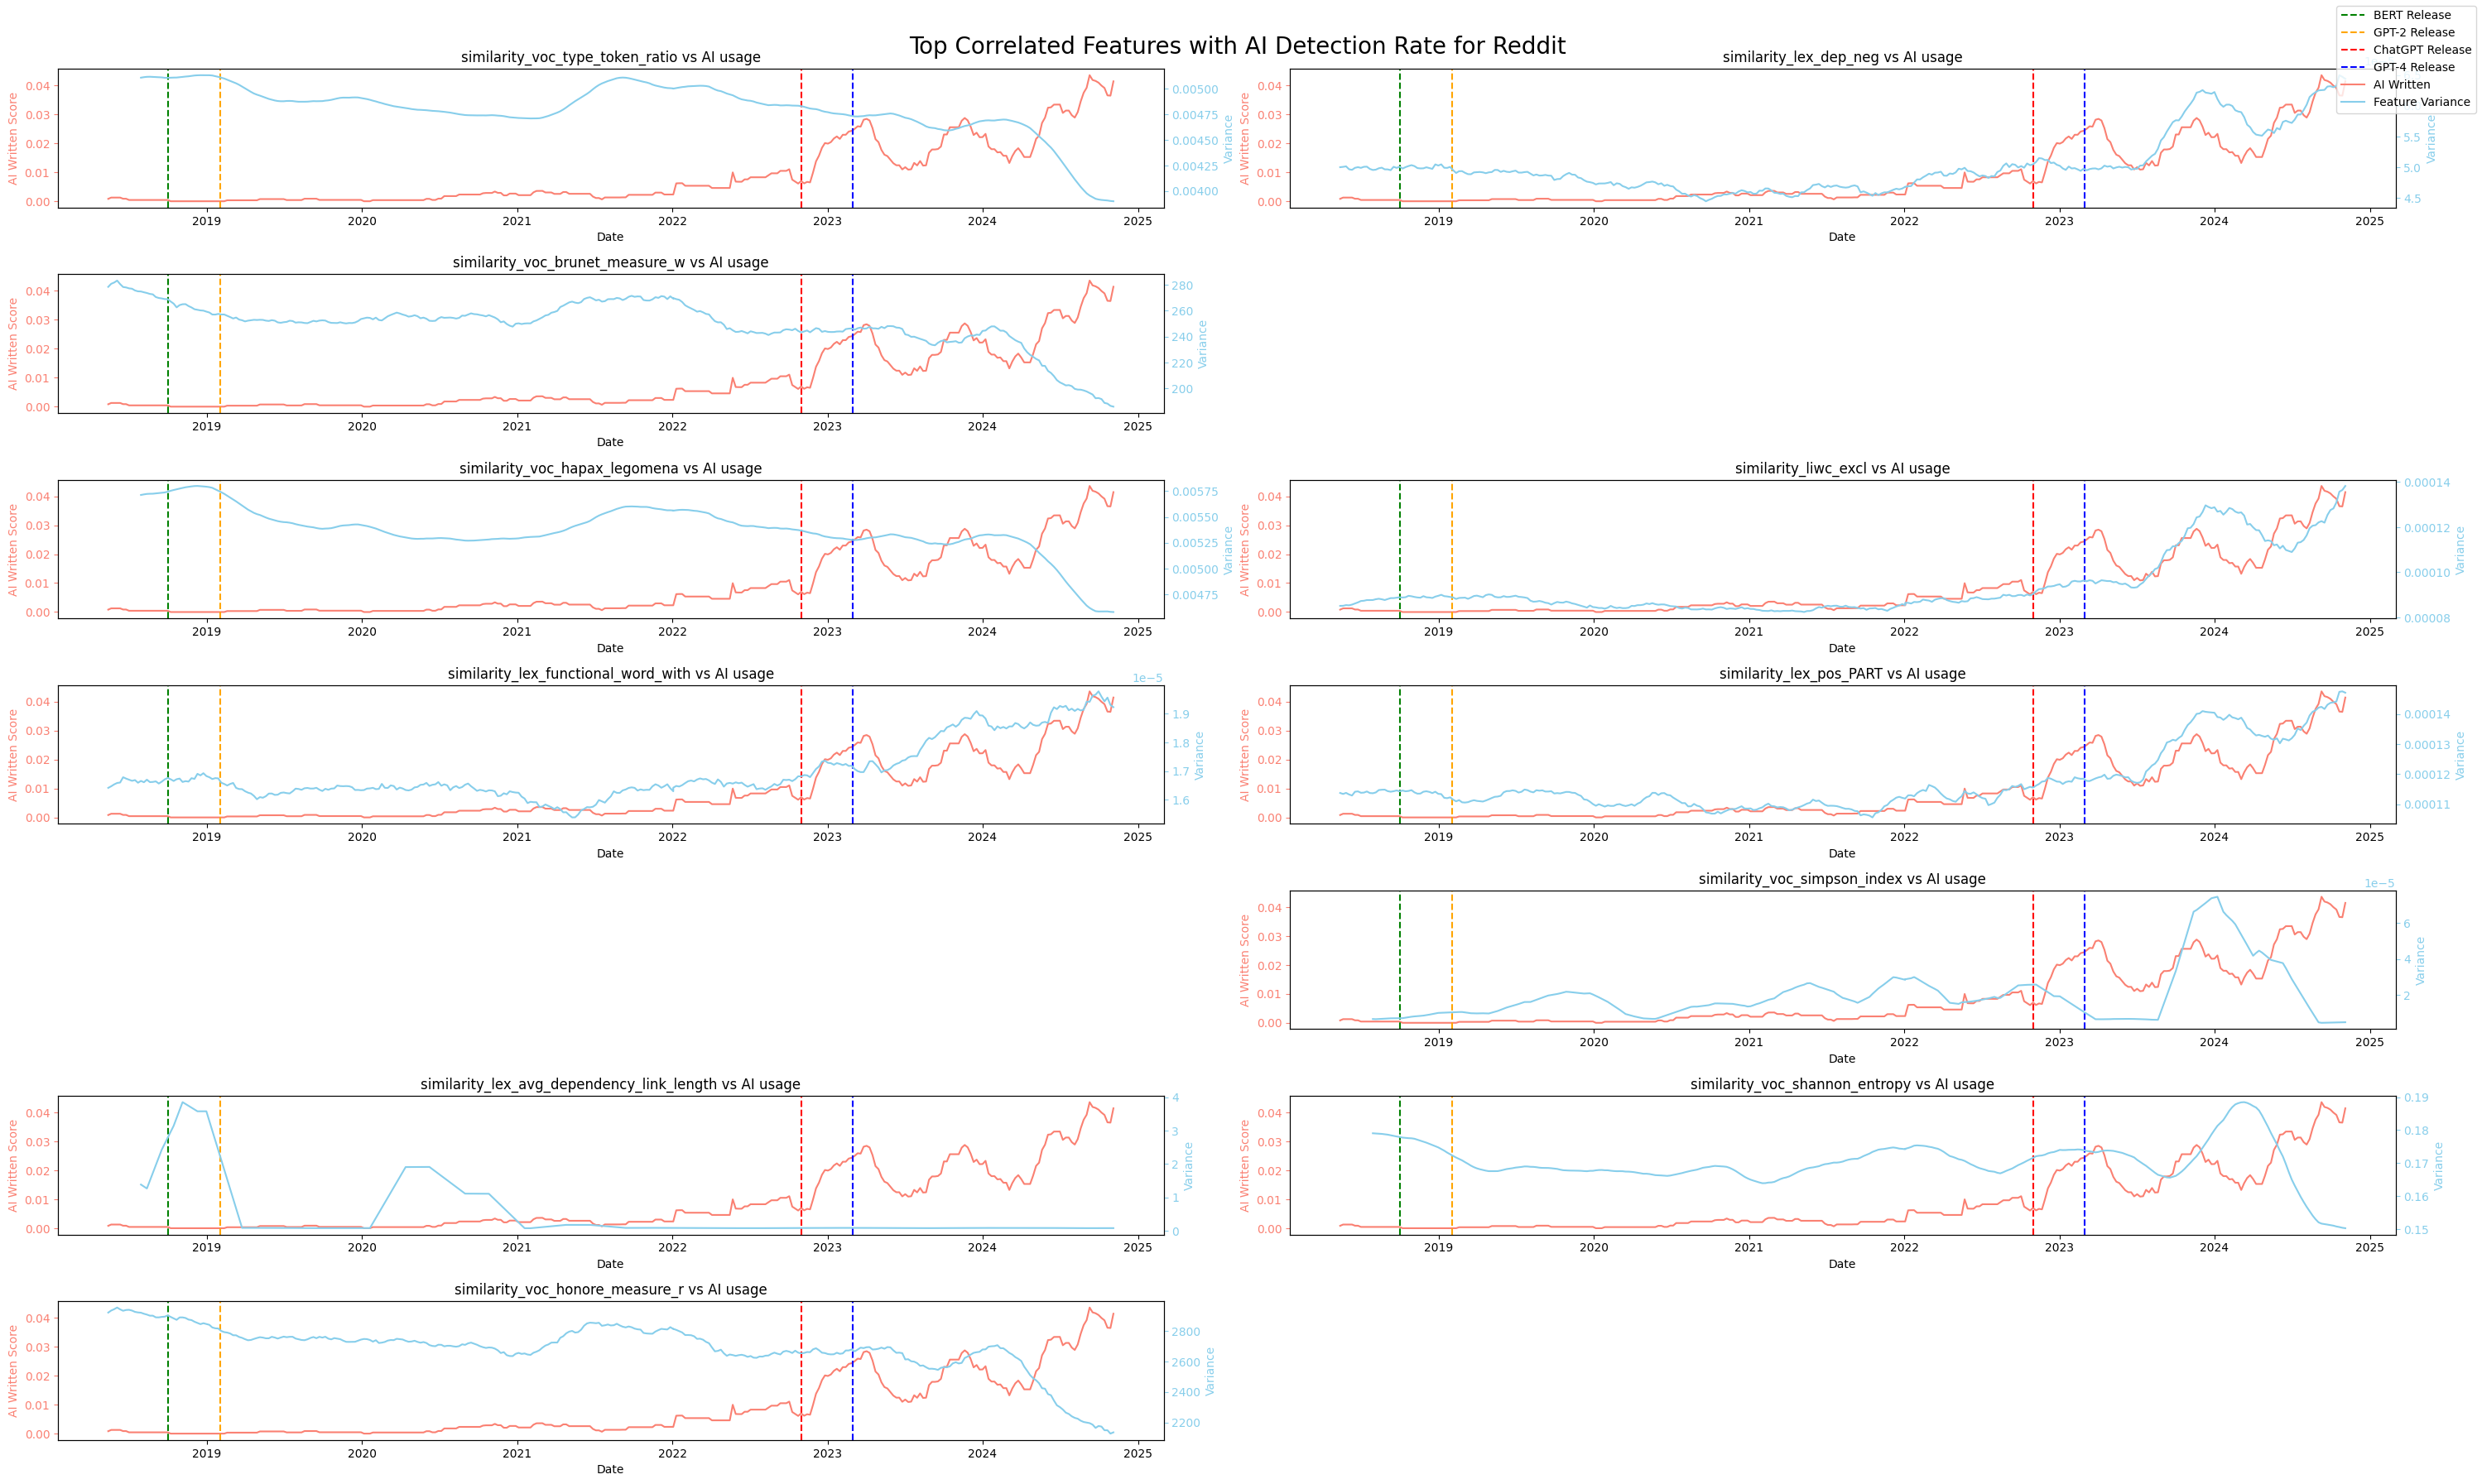

In [106]:
for cor_df, main_df, fig_title in zip(
    [
        papers_ai_top_correlated_df,
        news_ai_top_correlated_df,
        reddit_ai_top_correlated_df,
    ],
    [papers_merged_df, news_merged_df, reddit_merged_df],
    ["Papers", "News", "Reddit"],
):

    main_df = main_df.copy()

    fig = plt.figure(figsize=(30, 20))
    fig.suptitle(
        f"Top Correlated Features with AI Detection Rate for {fig_title}", fontsize=20
    )

    for i, feature in enumerate(cor_df.index):
        if feature == "ai_written" or feature == "date":
            continue
        ax = plt.subplot(8, 2, i + 1)
        ax2 = ax.twinx()  # Create a second y-axis sharing the same x-axis

        # Plot AI Written on left y-axis
        line1 = ax.plot(
            main_df["date"],
            main_df["ai_written"].rolling(window=20).mean(),
            label="AI Written",
            color="salmon",
        )

        # Plot feature on right y-axis
        line2 = ax2.plot(
            main_df["date"],
            main_df[feature].rolling(window=20).mean(),
            label="Feature Variance",
            color="skyblue",
        )

        ax.set_ylabel("AI Written Score", color="salmon")
        ax2.set_ylabel("Variance", color="skyblue")
        ax.set_xlabel("Date")
        ax.set_title(f"{feature} vs AI usage")

        # Combine legends from both axes
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        # ax.legend(lines, labels)

        # Color the tick labels to match the lines
        ax.tick_params(axis="y", colors="salmon")
        ax2.tick_params(axis="y", colors="skyblue")

        # Use actual dates instead of indices for the vertical lines
        bert_date = pd.to_datetime("2018-10-01")
        gpt2_date = pd.to_datetime("2019-02-01")
        chatgpt_date = pd.to_datetime("2022-11-01")
        gpt4_date = pd.to_datetime("2023-03-01")

        # Plot vertical lines at actual dates
        ax.axvline(x=bert_date, color="green", linestyle="--")
        ax.axvline(x=gpt2_date, color="orange", linestyle="--")
        ax.axvline(x=chatgpt_date, color="red", linestyle="--")
        ax.axvline(x=gpt4_date, color="blue", linestyle="--")

    # make a legend for the lines of the models with their colors and names
    models_legend = [
        plt.Line2D([0], [0], color="green", linestyle="--", label="BERT Release"),
        plt.Line2D([0], [0], color="orange", linestyle="--", label="GPT-2 Release"),
        plt.Line2D([0], [0], color="red", linestyle="--", label="ChatGPT Release"),
        plt.Line2D([0], [0], color="blue", linestyle="--", label="GPT-4 Release"),
        plt.Line2D([0], [0], color="salmon", label="AI Written"),
        plt.Line2D([0], [0], color="skyblue", label="Feature Variance"),
    ]
    # draw this for the figure
    fig.legend(handles=models_legend, loc="upper right")
    plt.tight_layout()
    plt.show()

In [107]:
papers_merged_df.shape, news_merged_df.shape, reddit_merged_df.shape

((360, 317), (307, 317), (359, 316))

In [108]:
papers_merged_df.to_csv("papers/papers_merged_weekly_df.csv", index=False)
news_merged_df.to_csv("news/news_merged_weekly_df.csv", index=False)
reddit_merged_df.to_csv("reddit/reddit_merged_weekly_df.csv", index=False)